# ÍNDICE

* 1. Introducción
* 2. Bibliotecas y dependencias
* 3. Datos
* 4. Modelo
    - 4.1. Creación
    - 4.2. Entrenamiento
    - 4.3. Validación
    - 4.4. Evaluación
* 5. Predicciones

## 1. INTRODUCCIÓN

En el siguiente código se pretende mostrar un ejemplo sencillo de funcionamiento de una red neuronal artificial (_ANN_), más concretamente, de tipo Secuencial.

Para ello, se entrena a la red con datos simulados de las horas de estudio para un examen, las horas de sueño el día anterior al mismo por parte de distintos alumnos y el resultado del examen (aprobado/suspendido). Una parte de estos datos se usa como conjunto de validación, para mejorar el rendimiento y las predicciones del modelo.

Una vez entrenada la red neuronal, se evalúa su rendimiento (mediante la extracción de diferentes métricas de evaluación) y se generan las predicciones de los nuevos datos.

Finalmente, se comentan los resultados obtenidos y la gráfica de predicciones.

## 2. BIBLIOTECAS Y DEPENDENCIAS

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 3. DATOS

Función para generar datos simulados

In [62]:
def generate_data(num_samples):
    """
    Generate study and sleep hours data using a normal distribution and scale the data.

    Args:
        num_samples (int): Number of samples to generate.

    Returns:
        numpy.ndarray, numpy.ndarray: Tuple containing arrays of study and sleep hours, and corresponding labels (presumably, X and y values)

    Summary:
        This function generates study and sleep hours data using a normal distribution with specified mean and standard deviation.
        It scales the generated data and clips the values to ensure they are within reasonable ranges.
        It calculates the probability of passing based on the study and sleep hours using a sigmoid function.
        Finally, it generates labels using the calculated probabilities.
    """

    # Genero horas de estudio y sueno usando una distribucion normal y escalando los datos
    study_hours = np.random.normal(loc=6, scale=4, size=num_samples)   # media=6, desviacion=4
    sleep_hours = np.random.normal(loc=6, scale=2, size=num_samples)   # media=6, desviacion=2

    # Reemplazo los valores por debajo (encima) del limite minimo (maximo) por dicho limite
    study_hours = np.clip(study_hours, a_min=0, a_max=25)              # máximo de 25 horas de estudio
    sleep_hours = np.clip(sleep_hours, a_min=0, a_max=12)              # máximo de 12 horas de sueño
    
    # Redondeo los valores existentes a un decimal
    study_hours = np.round(study_hours, 1)
    sleep_hours = np.round(sleep_hours, 1)
    
    # Calculo la probabilidad de aprobar basada en las horas de estudio y sueño
    probabilities = 1 / (1 + np.exp(-0.5 * (study_hours + sleep_hours - 12)))  # sigmoide que se centra alrededor de 12 horas combinadas
    labels = np.random.binomial(1, probabilities)                              # genero etiquetas (0 o 1) usando la probabilidad calculada
    
    return np.column_stack((study_hours, sleep_hours)), labels

Aplicación de la función anterior y visualización de los 10 primeros datos

In [63]:
# Genero 100 muestras
X_extended, y_extended = generate_data(100)

# Imprimo ejemplos de los "n" primeros datos generados
n = 10
print(f"Ejemplo de las primeros {n} características (horas de estudio, horas de sueño) y etiquetas (1 = aprobado, 0 = no aprobado) generadas:")
for i, (x, y) in enumerate(zip(X_extended[:n], y_extended[:n])):
    print(f"{x[0]}, {x[1]}   -   {y}")

Ejemplo de las primeros 10 características (horas de estudio, horas de sueño) y etiquetas (1 = aprobado, 0 = no aprobado) generadas:
3.1, 4.0   -   0
4.4, 4.3   -   0
3.9, 7.3   -   1
10.1, 7.2   -   1
4.3, 7.1   -   1
1.3, 4.5   -   0
3.2, 6.8   -   0
4.6, 5.6   -   0
7.2, 5.9   -   0
7.5, 2.6   -   0


## 4. MODELO

### 4.1. Creación

Modelo: RNA Secuencial (para aprendizaje supervisado).

Arquitectura del modelo:
- Capa inicial: 2 neuronas, una por cada característica de entrada (horas de estudio - horas de sueño).
- Primera capa oculta: capa densa de 8 neuronas y función de activación ReLU.
- Capa de Dropout: capa para prevenir el sobreajuste al "desactivar" aleatoriamente algunas neuronas (20%) durante el entrenamiento.
- Segunda oculta: capa densa de 4 neuronas y función de activación ReLU.
- Capa de salida: 1 neurona, con función de activación sigmoide para indicar la probabilidad de la muestra de pertenecer a la clase 1 (aprobado).

In [64]:
# Creo el modelo (2-8-4-1)
model = Sequential([
    Input(shape=(2,)),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilo el modelo
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[BinaryAccuracy(name='accuracy'),
                       Precision(name='precision'),
                       Recall(name='recall'),
                       AUC(name='auc')])

### 4.2. Entrenamiento

División de los datos X e y entre conjuntos de entrenamiento y de validación:

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_extended, y_extended, test_size=0.25, random_state=42)

Entrenamiento del modelo

In [66]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_data=(X_val, y_val))

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4660 - auc: 0.2249 - loss: 2.0059 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4400 - val_auc: 0.1364 - val_loss: 1.7916 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4783 - auc: 0.2169 - loss: 1.9003 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4400 - val_auc: 0.1494 - val_loss: 1.3965 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5602 - auc: 0.3829 - loss: 1.0782 - precision: 0.6833 - recall: 0.0462 - val_accuracy: 0.4400 - val_auc: 0.1623 - val_loss: 1.1347 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5600 - auc: 0.2750 - loss: 1.0497 - precision: 0.1869 - recall: 0.0332 - val_accuracy: 0.4400 - val_auc: 0.1591 - val_loss: 0.9429 - val_precision: 0.0000e+00 - val_recall

### 4.3. Validación

Graficar las pérdidas y precisión de entrenamiento y validación frente a las épocas.

- Pérdidas (loss): 
    - Entrenamiento: muestran cuánto error comete el modelo en cada época durante el entrenamiento en el conjunto de datos de entrenamiento.
    - Validación: muestran cuánto error comete el modelo en cada época en un conjunto de datos de validación, que no se utiliza para entrenar el modelo pero sí para evaluar su rendimiento.

Normalmente, se espera obtener un descenso rápido en las primeras épocas (el modelo aprende de manera efectiva), una estabilización (el modelo llega al límite, no puede aprender más) y una brecha entre train y val lo más pequeña posible (no existe sobreajuste).

- Precisión (accuracy):
    - Entrenamiento: porcentaje de predicciones correctas.
    - Validación: lo mismo.

Normalmente, se espera obtener un aumento de la precisión en las primeras épocas (el modelo aprende de manera efectiva), una estabilización (el modelo llega al límite, no puede aprender más) y una brecha lo más pequeña posible.

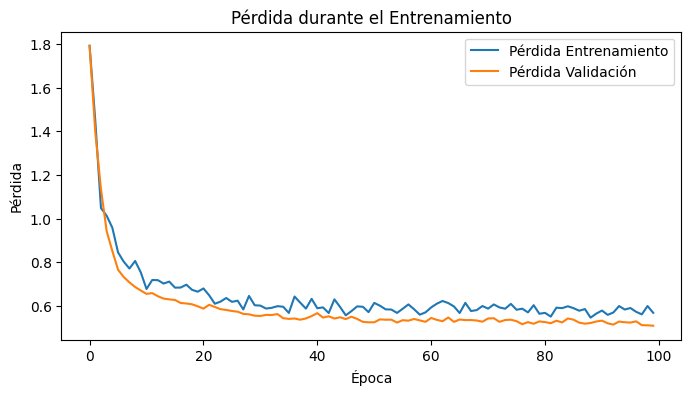

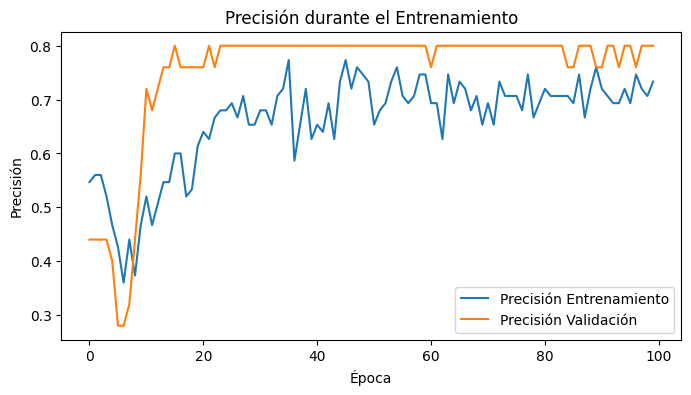

In [67]:
# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()

# Graficar la precisión de entrenamiento y validación
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.title('Precisión durante el Entrenamiento')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

### 4.4. Evaluación

Evaluación del modelo:

- loss (pérdida): valor de la función de pérdida (entropy cross-validation)
- accuracy (exactitud): porcentaje de predicciones correctas sobre el total de casos evaluados
- precision (precisión): proporción de predicciones positivas que fueron realmente correctas
- recall (sensibilidad): proporción de casos positivos reales que fueron correctamente identificados
- AUC (área bajo la curva ROC): capacidad del modelo para discriminar entre clases positivas/negativas

In [68]:
# Evaluar el modelo
results = model.evaluate(X_val, y_val)
print(f"Validation Loss: {results[0] * 100:.2f}%")
print(f"Validation Accuracy: {results[1] * 100:.2f}%")
print(f"Validation Precision: {results[2] * 100:.2f}%")
print(f"Validation Recall: {results[3] * 100:.2f}%")
print(f"Validation AUC: {results[4] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8000 - auc: 0.8442 - loss: 0.5093 - precision: 0.9091 - recall: 0.7143
Validation Loss: 50.93%
Validation Accuracy: 80.00%
Validation Precision: 90.91%
Validation Recall: 71.43%
Validation AUC: 84.42%


## 5. PREDICCIONES

Conjunto de test y predicciones

In [92]:
new_data_x = generate_data(25)[0]

prediction = model.predict(new_data_x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Representación gráfica de los datos train/val/test

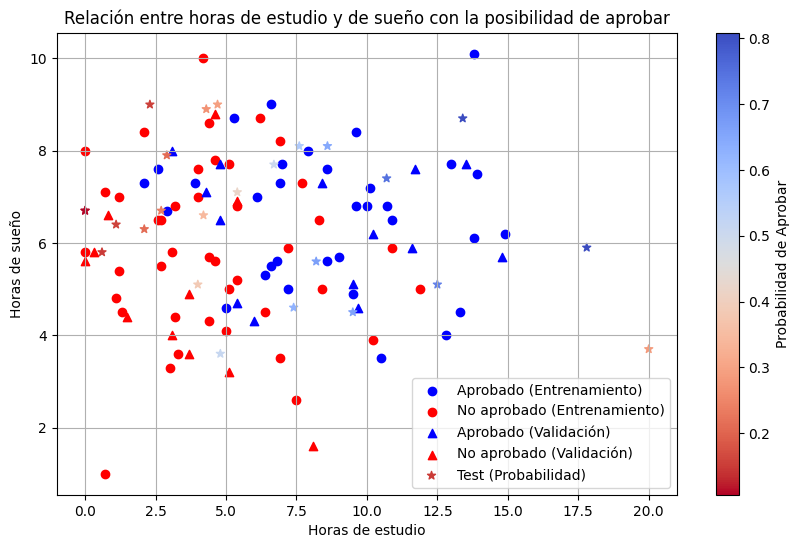

In [93]:
# Separar los datos de entrenamiento y validación según las etiquetas
X_train_approved = X_train[y_train == 1]
X_train_failed = X_train[y_train == 0]
X_val_approved = X_val[y_val == 1]
X_val_failed = X_val[y_val == 0]

# Creación de la gráfica
plt.figure(figsize=(10, 6))

# Dibujar datos de entrenamiento y validación
plt.scatter(X_train_approved[:, 0], X_train_approved[:, 1], c='blue', label='Aprobado (Entrenamiento)', marker='o')
plt.scatter(X_train_failed[:, 0], X_train_failed[:, 1], c='red', label='No aprobado (Entrenamiento)', marker='o')
plt.scatter(X_val_approved[:, 0], X_val_approved[:, 1], c='blue', label='Aprobado (Validación)', marker='^')
plt.scatter(X_val_failed[:, 0], X_val_failed[:, 1], c='red', label='No aprobado (Validación)', marker='^')

# Usar la intensidad de color para representar la probabilidad en los datos de test
# Aprobados con color más intenso cerca de 1, y no aprobados cerca de 0
colors = prediction.ravel()  # Aplanar el array de predicciones para usar como intensidad de color
scatter = plt.scatter(new_data_x[:, 0], new_data_x[:, 1], c=colors, cmap='coolwarm_r', label='Test (Probabilidad)', marker='*')

# Añadir barra de color para indicar la escala de probabilidad
plt.colorbar(scatter, label='Probabilidad de Aprobar')

# Configuración del gráfico
plt.xlabel('Horas de estudio')
plt.ylabel('Horas de sueño')
plt.title('Relación entre horas de estudio y de sueño con la posibilidad de aprobar')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()